In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from apyori import apriori
from collections import defaultdict
from surprise import Reader
from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate
from scipy.sparse import csr_matrix

<h3>Let's fetch our anime data</h3>

In [42]:
animelist = pd.read_csv('anime/anime.csv', sep=',')
animelist.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [43]:
animelist.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


<h3>Let's fetch Users anime ratings</h3>

In [4]:
ratings = pd.read_csv('anime/rating.csv', sep=',')
ratings = ratings[ratings.rating != -1]
ratings.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [5]:

ratings.describe()

,user_id,anime_id,rating
count,6.337241e+06,6.337241e+06,6.337241e+06
mean,3.674791e+04,8.902866e+03,7.808497e+00
std,2.101340e+04,8.882000e+03,1.572496e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.898400e+04,1.239000e+03,7.000000e+00
50%,3.681500e+04,6.213000e+03,8.000000e+00
75%,5.487300e+04,1.407500e+04,9.000000e+00
max,7.351600e+04,3.447500e+04,1.000000e+01


<h3>Bar Graph</h3>
<p>From bar graph we can see our rating data which has been classified from 1 to 10</p> 

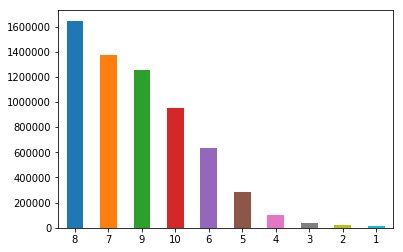

In [8]:
prob = ratings['rating'].value_counts()
prob.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

<h3>Splitting data</h3>
<p>MemoryError                               Traceback (most recent call last)</p>
<p>
ipython-input-21-7b20asd464c98 in module</p>
 <p> algo = KNNBasic(sim_options=sim_options)
--- 11 algo.fit(trainset)</p>
<br>
<p>Due to 'MemoryError' I was no able to fit my data so I splitted the data to smaller parts. First I tried to split the data to 5 parts but it did not work because it crashed my computer so I decided to split it to 1000 groups just to be secure.</p>

In [11]:
#I am splitting my data to 1000 parts and shuffling it so that we get more realistic data set 
shuffled_data = ratings.reindex(np.random.permutation(ratings.index))
group = np.array_split(shuffled_data, 1000)
smaller_ratings = group[0]


In [12]:
smaller_ratings.head()

,user_id,anime_id,rating
3094548,28598,14073,6
1888117,18313,9919,7
151882,1522,31098,7
2209068,21360,1030,9
4457485,42053,9041,7


In [13]:
smaller_ratings.describe()

,user_id,anime_id,rating
count,6338.000000,6338.000000,6338.000000
mean,36944.387662,9072.826759,7.837015
std,21187.625984,8826.787221,1.535886
min,7.000000,1.000000,1.000000
25%,19124.500000,1498.000000,7.000000
50%,36516.000000,6547.000000,8.000000
75%,55256.500000,14289.000000,9.000000
max,73515.000000,34240.000000,10.000000


<h3>Bar Graph</h3>
<p>As we can see the graph looks lot of like the previous graph because we mixed the data. </p>

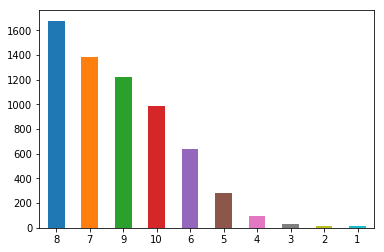

In [276]:
prob = smaller_ratings['rating'].value_counts()
prob.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

<h3>Lets fit our data</h3>

In [15]:
# Construct reader
reader = Reader(rating_scale=(1, 10))

# Generate surprise Dataset
data = Dataset.load_from_df(smaller_ratings[['user_id', 'anime_id', 'rating']], reader)

In [16]:
# Set all data as training set
trainset = data.build_full_trainset()

# Build and train an algorithm.

sim_options = {
               'user_based': True  # compute  similarities between items
}

algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


<h2>Predictions</h2>
<h3>Now to the recommendation part</h3>
<p>Lets see how well our model is able to recommend different animes to different users</p>

In [137]:

#From this function we can find out animes name with the anime id 
def getAnimeNameById(animeid):
    return animelist.name[animelist.index[animelist['anime_id']==animeid].tolist()[0]]


In [264]:
#From this function we can find out if user has already rated anime 
def doesContain(userid,animeid):
    va=smaller_ratings[smaller_ratings.user_id==userid].anime_id.isin([animeid])
    for j in va:
        if(j):
            return j
    return False

<h3>Some logic to our recommendation system</h3>
<p>Most of the time we got "'was_impossible': True" because it could not find 'neighbor' close enough so I dummy automated it.
    <br>
I wanted to find out the first user from the ratings list who would be somehow intrested about 
anime id 9041 'Infinite Stratos' (randomly picked anime.. personally would recommend 'One Punch Man'). Also the recommended anime should not be already rated by the user.</p>

In [269]:
anime_id = 9041 #count is 36
user_id = 0

for i in smaller_ratings.user_id:
    user_id = i
    pred = algo.predict(user_id, anime_id, verbose=False)
    if(pred.details['was_impossible'] == False and doesContain(user_id,anime_id) == False):
        p=pred
        break
print(p)    

user: 48916      item: 9041       r_ui = None   est = 7.00   {'actual_k': 1, 'was_impossible': False}


In [270]:
# Sample prediction

print('Name of the anime: ', getAnimeNameById(anime_id))

Name of the anime:  IS: Infinite Stratos


<p>We got user 48916 who would probably be interested about the anime 9041 </p>

In [272]:
#list of users who has rated the 9041 anime
smaller_ratings[smaller_ratings.anime_id == anime_id]

,user_id,anime_id,rating
4457485,42053,9041,7
3968356,37565,9041,6
3572825,33116,9041,3
4847557,46256,9041,5
383942,3949,9041,7
1603473,15554,9041,7
4003220,37929,9041,7
2010505,19489,9041,8
4011136,38016,9041,7


In [275]:
cross_validate(algo, data, measures=['MAE', 'RMSE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
MAE (testset)     1.2335  1.2020  1.1829  1.2061  0.0209  
RMSE (testset)    1.5515  1.5540  1.5020  1.5358  0.0239  
Fit time          0.25    0.26    0.26    0.26    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    


{'test_mae': array([1.23348412, 1.2019682 , 1.18285097]),
 'test_rmse': array([1.55149497, 1.55397227, 1.50199567]),
 'fit_time': (0.25332069396972656, 0.25531673431396484, 0.2593064308166504),
 'test_time': (0.013962745666503906,
  0.01396322250366211,
  0.012965917587280273)}

<h2>Conclusions</h2>
<br>
<p>
We fetched anime data which contained data about different animes and then we also fetched ratings data which contained users ratings. We had to split the data because KNN will compare each user_id to anime_id and build different sets which also will be compared so this does not suprise me that the process might take lot of processing power. When we got the model we were ready to make some predictions/recommendations.  
</p>